In [133]:
import numpy as np
import pandas as pd
from shutil import copyfile
from astropy.cosmology import Planck13 as cosmo
import fsps
from matplotlib import gridspec
import matplotlib as mpl
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
from sim_engine import Scale_model
from spec_tools import Source_present, Oldest_galaxy, Sig_int, Smooth, Rescale_sfh, lbt_to_z, boot_to_posterior, age_to_z, Posterior_spec
from spec_stats import Smooth, Highest_density_region
from spec_id import *
from spec_stats import Highest_density_region, Linear_fit
from spec_exam import Gen_spec
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from sim_engine import forward_model_grism

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [20]:
morph_db = pd.read_pickle('../dataframes/fitdb/tabfitdb.pkl')

inout = []
for i in morph_db.index:
    for ii in range(len(morph_db.zgrism_hci[i])//2):
        if morph_db.zgrism_hci[i][2*ii] <= morph_db.zgrism[i] <= morph_db.zgrism_hci[i][2*ii+1]:
            if(morph_db.zgrism_hci[i][2*ii+1] - morph_db.zgrism_hci[i][2*ii]) /( 2 * (1 + morph_db.zgrism[i])) < 0.01:
                inout.append('i')
            else:
                inout.append('o')
        
morph_db['inout'] = inout
morph_db = morph_db.query('inout == "i" and n_f < 3 and Re < 20')

mdb = morph_db.query('n_f < 3 and lmass >= 10.5')
mdbMC = morph_db.query('n_f < 3 and zgrism <= 2 and lmass >= 10.5')
mdbMC2 = morph_db.query('n_f < 3 and lmass >= 11.0')
mdbG = morph_db.query('n_f < 2 and lmass >= 10.5')


In [38]:
field = 'GSD'
galaxies =41520

grow = morph_db.query('id == {0}'.format(galaxies))

Gs = Gen_spec(field, galaxies, grow.zgrism.values[0], phot_errterm = 0.04, irac_err = 0.08) 
Flam = Posterior_spec(field, galaxies)

x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pbp1.npy'.format(field, galaxies))
bp1 = x[px == max(px)][0]
x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Prp1.npy'.format(field, galaxies))
rp1 = x[px == max(px)][0]

Gs.Best_fit_scale_flam(Flam.wave, Flam.SPEC, Flam.rshift, bp1, rp1)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


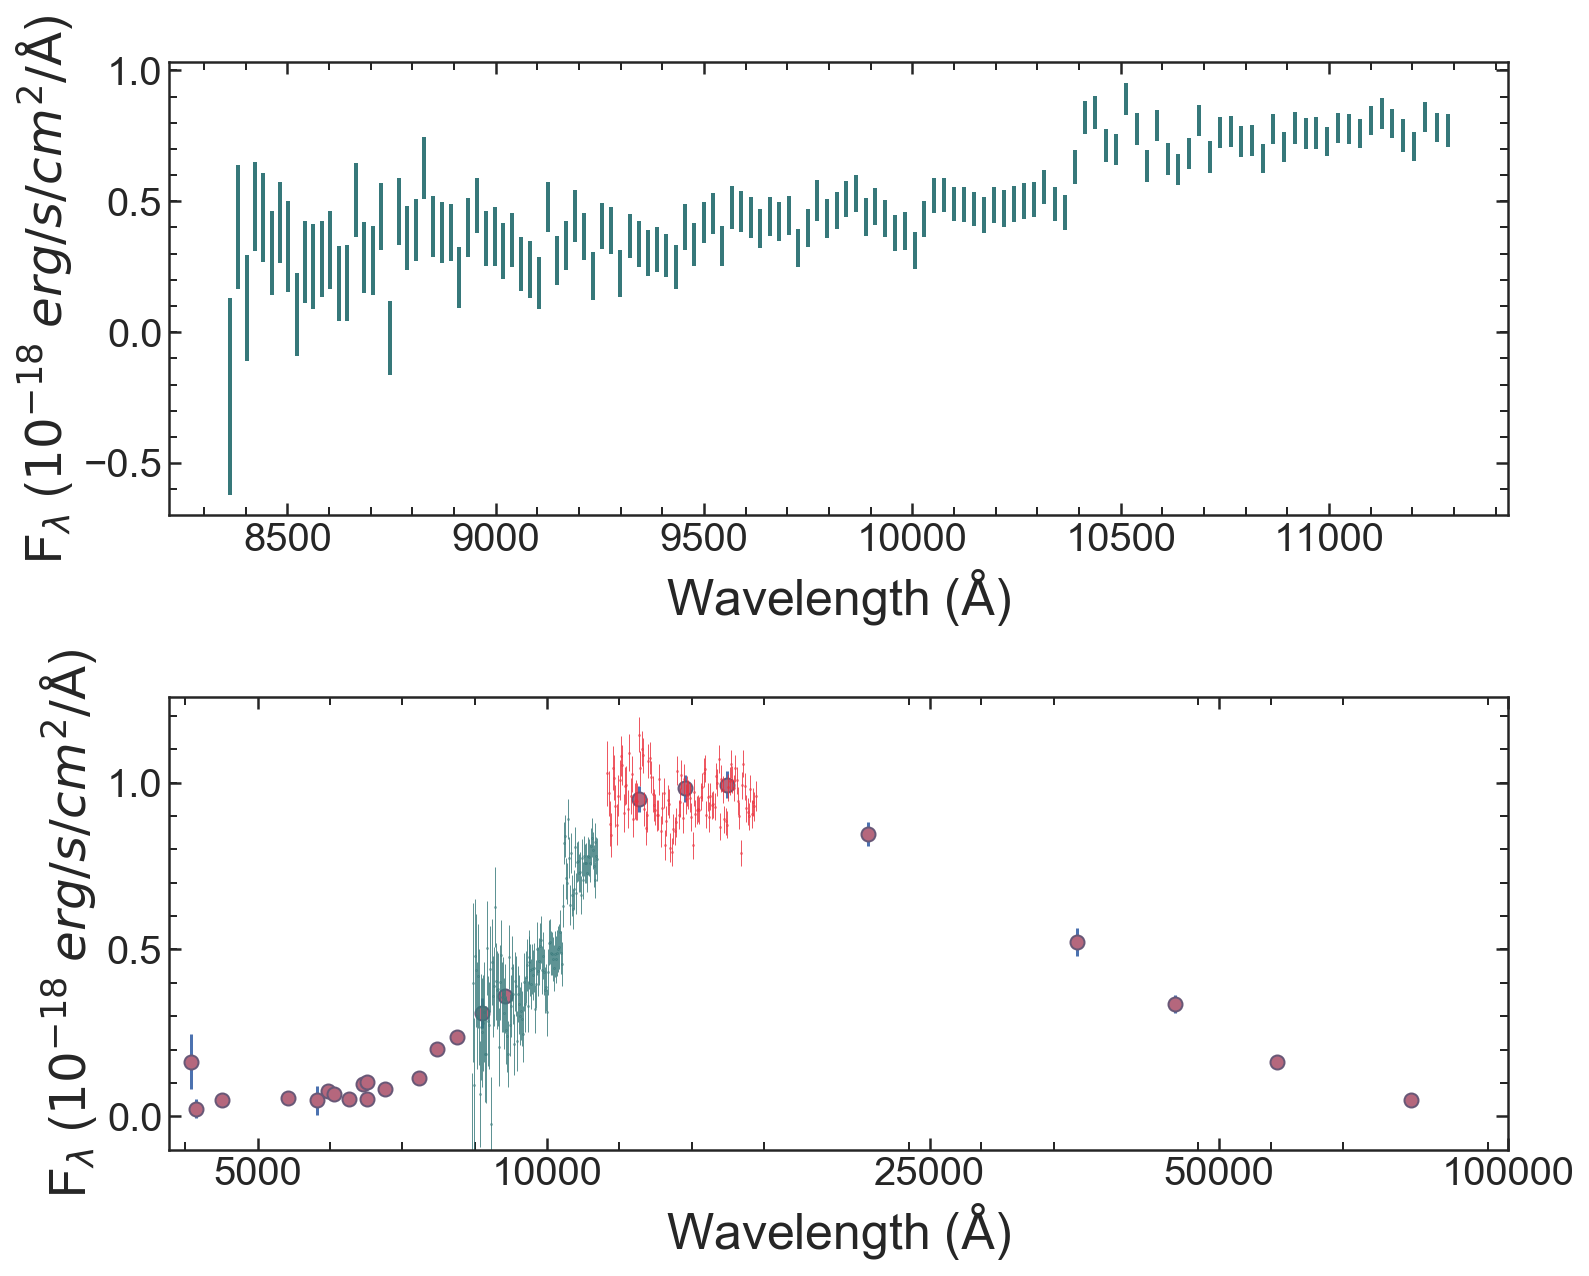

In [39]:
gs = gridspec.GridSpec(2,1, hspace=0.4)

plt.figure(figsize= [12,10])
##############plot tab##################
plt.subplot(gs[0])
plt.errorbar(Gs.Bwv,Gs.Bfl *1E18,Gs.Ber *1E18,
        linestyle='None', marker='o', markersize=0.5, color='#36787A', zorder = 2, elinewidth = 2)

plt.xlabel(r'Wavelength ($\rm \AA$)', fontsize=25)
plt.ylabel(r'F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/ \rm \AA $)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.minorticks_on()

plt.subplot(gs[1])
plt.errorbar(np.log10(Gs.Bwv),Gs.Bfl *1E18,Gs.Ber *1E18,
        linestyle='None', marker='o', markersize=0.25, color='#36787A', zorder = 2, elinewidth = 0.4)

plt.errorbar(np.log10(Gs.Rwv),Gs.Rfl *1E18,Gs.Rer *1E18,
        linestyle='None', marker='o', markersize=0.25, color='#EA2E3B', zorder = 2, elinewidth = 0.4)

plt.errorbar(np.log10(Gs.Pwv),Gs.Pflx*1E18,Gs.Perr*1E18,
        linestyle='None', marker='o', markersize=7, markerfacecolor='#B5677D', zorder = 1,
             markeredgecolor = '#685877',markeredgewidth = 1)

plt.xlim(np.log10(min(Gs.Pwv)*0.95),np.log10(max(Gs.Pwv_rf)*1.05))
plt.ylim(-0.1,max(Gs.Rfl *1E18)*1.1)

plt.xticks(np.log10([5000,10000,25000, 50000, 100000]),np.array([5000,10000,25000, 50000, 100000]))
plt.xlabel(r'Wavelength ($\rm \AA$)', fontsize=25)
plt.ylabel(r'F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/ \rm \AA $)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.minorticks_on()
plt.savefig('../plots/presentation_plots/41520_2spec.png', bbox_inches = 'tight')

In [2]:
sfh = Rescale_sfh('GSD',41520)

In [94]:
from spec_tools import Gen_PPF

class Sfh_prior_single(object):
    def __init__(self, field, galaxy, a, lm,trials = 1000):

        idx = 0
        x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pz.npy'.format(field, galaxy))
        rshift = x[px == max(px)][0]
        self.fulltimes = get_agebins(a).flatten()
        sfr_grid = []

        while idx < trials:
            taus = stats.t.ppf( q = np.random.rand(10), loc = 0, scale = 0.3, df =2.)
            masses = logsfr_ratios_to_masses(logmass = 0, logsfr_ratios = taus, agebins = get_agebins(a))

            time, sfr, tmax = convert_sfh(get_agebins(a), masses, maxage = a*1E9)

            lbt = np.abs(time - time[-1])[::-1]
            lbsfr = sfr[::-1]

            sfr_grid.append(lbsfr)

            idx +=1
        SFH = []
        SFH_16 = []
        SFH_84 = []
        ftimes = []
        for i in range(len(np.array(sfr_grid).T)):
            adat = np.array(np.array(sfr_grid).T[i])
            SFH.append(np.percentile(adat,50))
            SFH_16.append(np.percentile(adat,16))
            SFH_84.append(np.percentile(adat,84))

        self.SFH = np.array(SFH)
        self.SFH_16 = np.array(SFH_16)
        self.SFH_84 = np.array(SFH_84)
        self.LBT = np.array(lbt)
        
        self.sfr_grid = np.array(sfr_grid)

In [110]:
prior = Sfh_prior_single('GSD',41520,max(sfh.fulltimes), mdb.query('id == 41520').lmass.values[0], trials=1000)

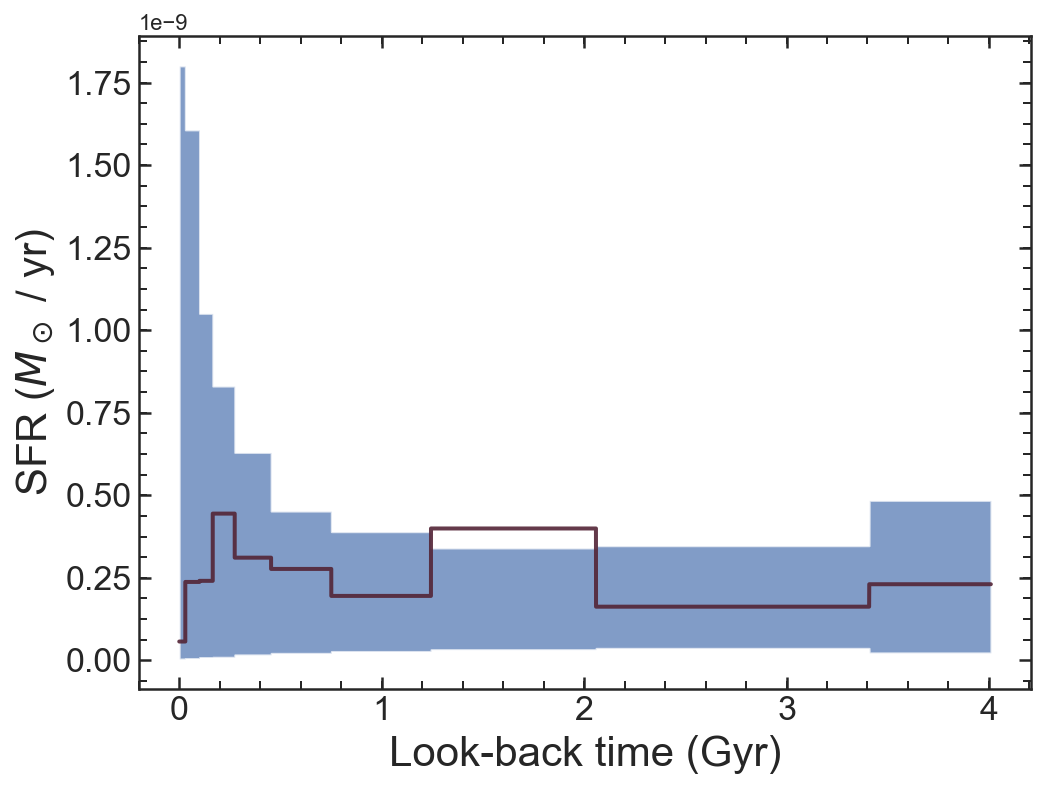

In [142]:
plt.figure(figsize= [8,6])

# plt.plot(sfh.fulltimes, sfh.sfr_grid[2], color = '#532436', linewidth = 5)
plt.xlabel('Look-back time (Gyr)', fontsize=21)
plt.ylabel('SFR ($M_\odot$ / yr)', fontsize=21)   
plt.tick_params(axis='both', which='major', labelsize=17)
plt.minorticks_on()

rns = [1,34,5,238,12,885]

# for r in rns:
plt.plot(prior.LBT, prior.sfr_grid[96], color = '#532436', linewidth = 2 ,alpha = 0.9)
plt.fill_between(prior.LBT, prior.SFH_84, prior.SFH_16, alpha = 0.7)

# plt.yscale('log')
# plt.xscale('log')
# plt.ylim(0.4E-14,0.4E-8)
plt.savefig('../plots/presentation_plots/sfh_example.png', bbox_inches = 'tight')

In [59]:
a = 4
lm=11

taus = stats.t.ppf( q = np.random.rand(10), loc = 0, scale = 0.3, df =2.)
masses = logsfr_ratios_to_masses(logmass = 0, logsfr_ratios = taus, agebins = get_agebins(a))

time, sfr, tmax = convert_sfh(get_agebins(a), masses, maxage = a*1E9)


T=[0]
M=[0]
for i in range(len(time)//2):
    mass = sfr[i*2+1] * (time[i*2+1] - time[i*2])
    M.append(M[i] + mass)
    T.append(time[i*2+1])

    
sfr = sfr/ M[-1] * 10**lm / 1E9

print(sfr)

lbt = np.abs(time - time[-1])[::-1]
lbsfr = sfr[::-1]

sfr_grid.append(lbsfr)

[31.10285558 31.10285558 36.63430524 36.63430524 15.67269379 15.67269379
 13.46444731 13.46444731  6.97857492  6.97857492 14.66545925 14.66545925
 24.29496482 24.29496482 25.32952592 25.32952592 50.80005573 50.80005573
  6.41436403  6.41436403]


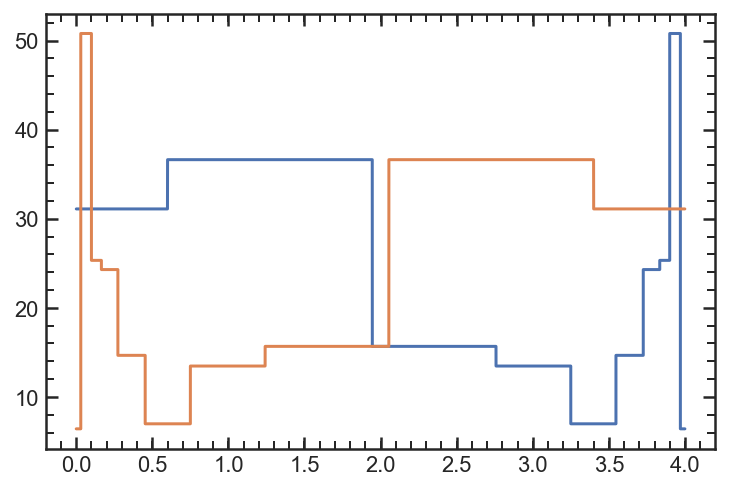

In [61]:
plt.plot(time,sfr)
plt.plot(lbt,lbsfr)

In [49]:

def Z_prior_mu(lmass):
    M = [9, 11.5]
    P = [-0.5813, 0.06818]
    iP = interp1d(M,P)
    return iP(lmass) 

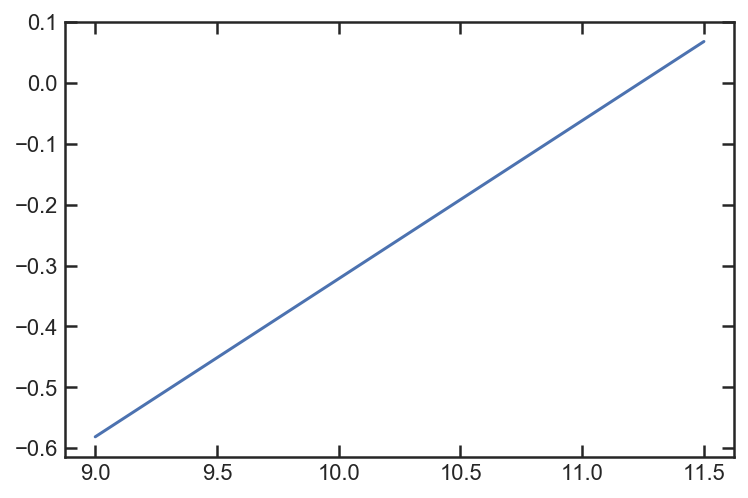

In [51]:
plt.plot(np.linspace(9.0,11.5), Z_prior_mu(np.linspace(9.0,11.5)))

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda

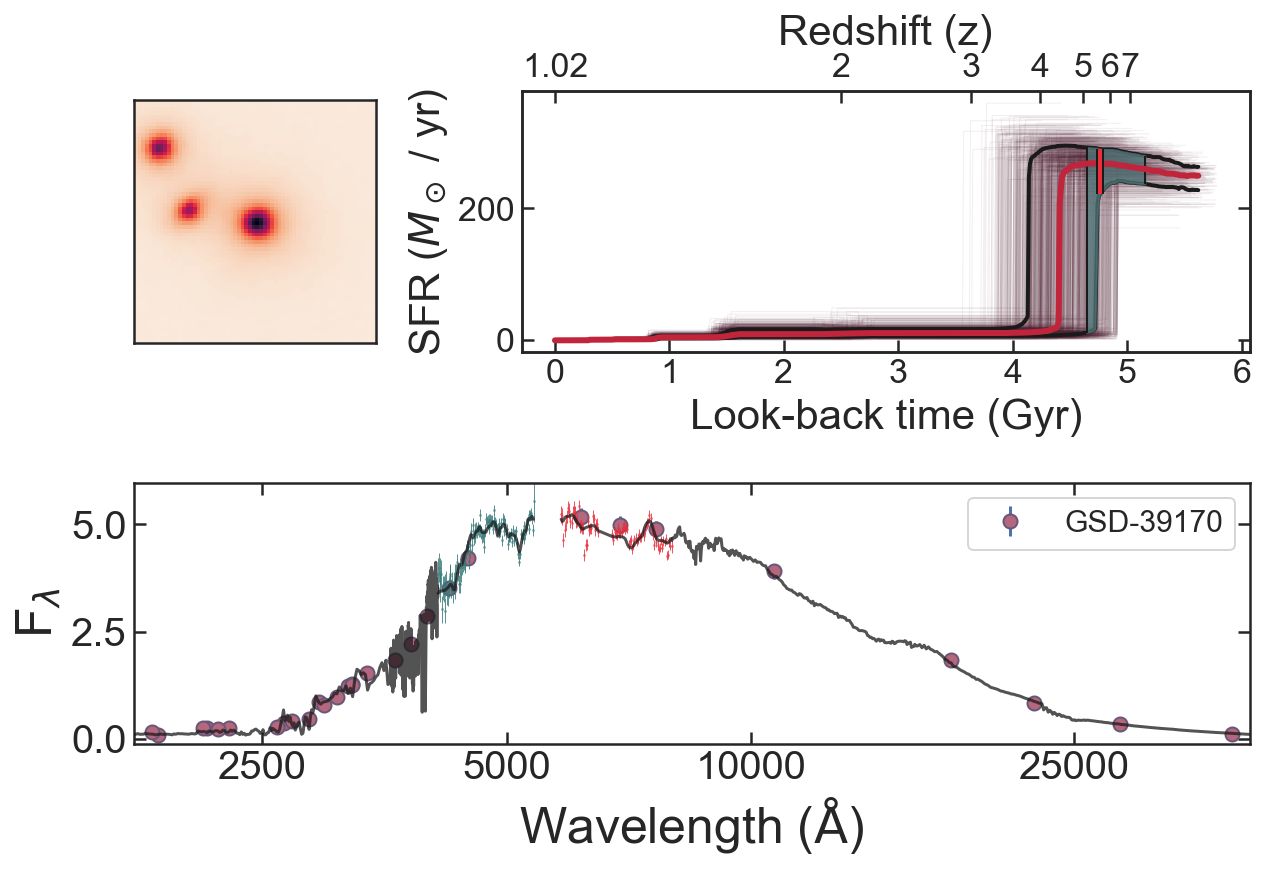

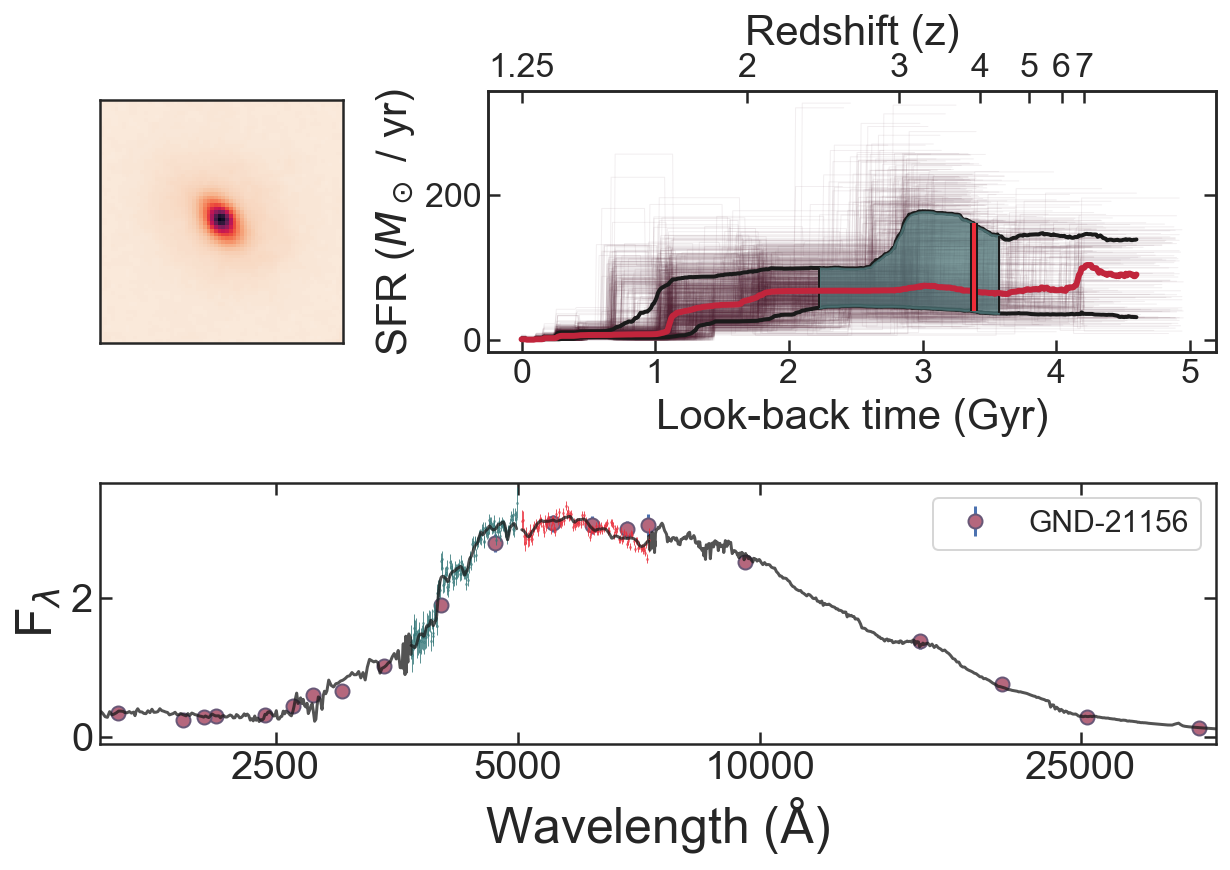

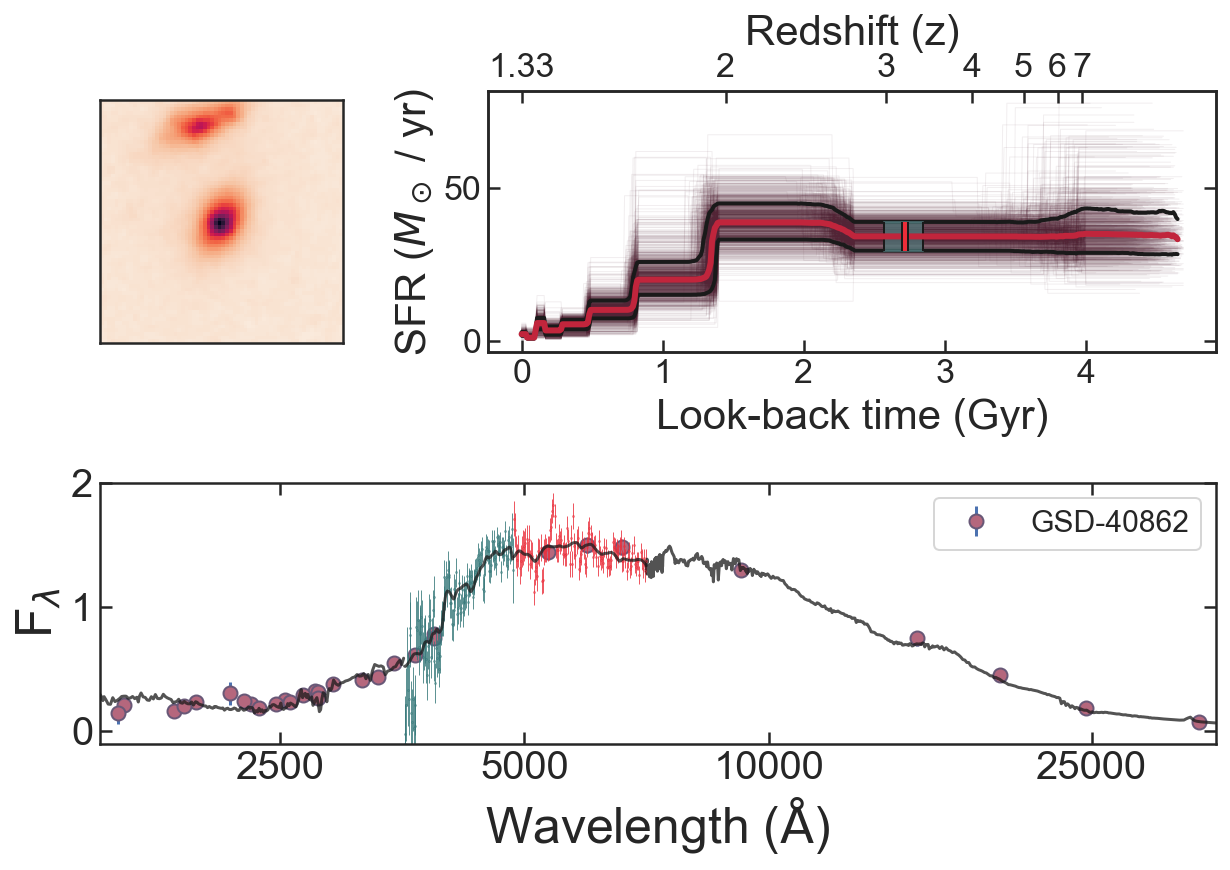

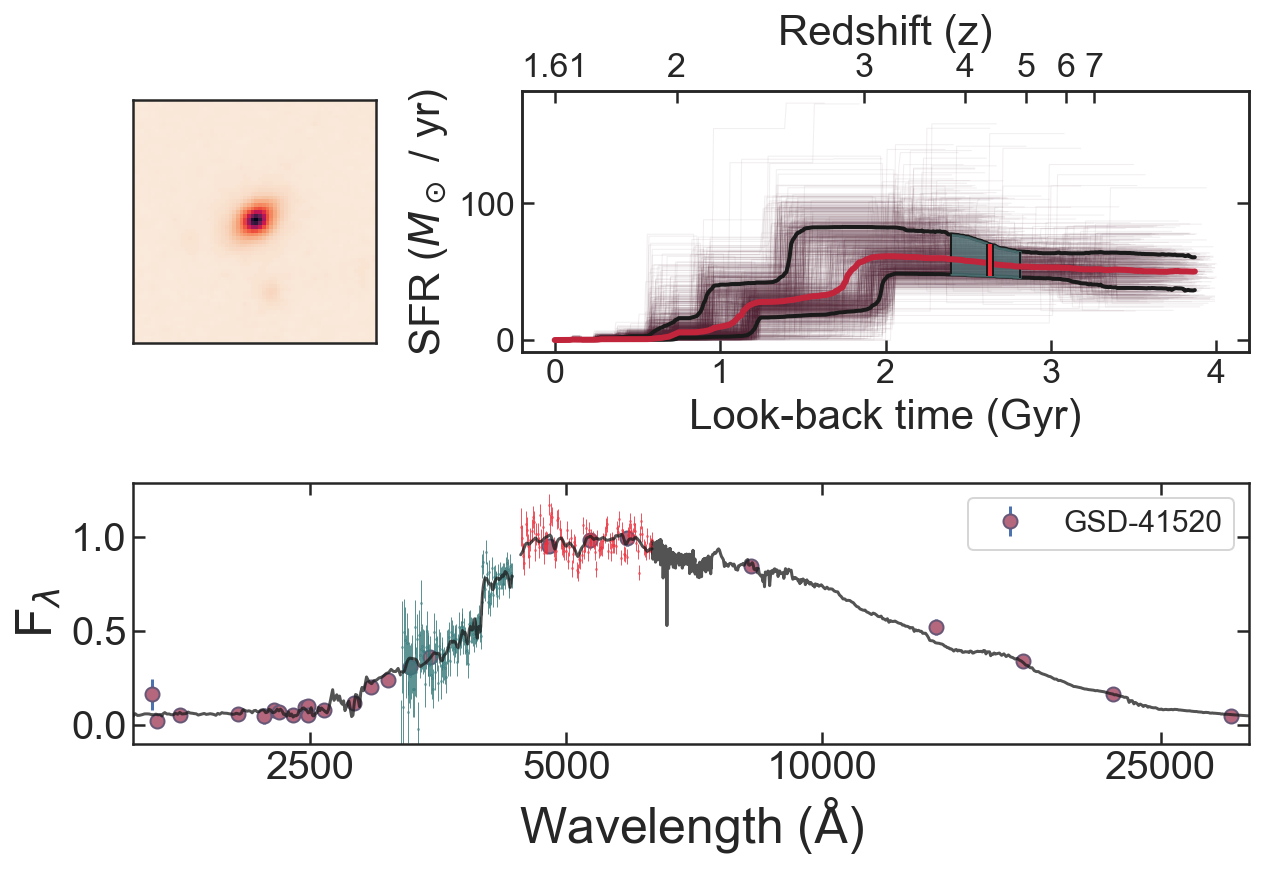

In [6]:
galaxies = [39170, 21156, 40862, 41520]
field = ['GSD','GND','GSD', 'GSD']

for i in range(len(galaxies)):

    plt.figure(figsize=[10,6])
    gsin = gridspec.GridSpec(2,2, width_ratios=[1,3], hspace=0.5, wspace=0.3)

    grow = morph_db.query('id == {0}'.format(galaxies[i]))

    rsimg = np.load('../data/imgfiles/{0}_{1}_rsimg.npy'.format(field[i], galaxies[i]))

    ax1 = plt.subplot(gsin[0,0])
    ax1.imshow(-np.arcsinh(rsimg))#, vmin = -1, vmax = 0.1)
    ax1.set_xticks([])
    ax1.set_yticks([])

    ax2 = plt.subplot(gsin[1,:])

    Gs = Gen_spec(field[i], galaxies[i], grow.zgrism.values[0], phot_errterm = 0.04, irac_err = 0.08) 
    Flam = Posterior_spec(field[i], galaxies[i])

    x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pbp1.npy'.format(field[i], galaxies[i]))
    bp1 = x[px == max(px)][0]
    x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Prp1.npy'.format(field[i], galaxies[i]))
    rp1 = x[px == max(px)][0]

    Gs.Best_fit_scale_flam(Flam.wave, Flam.SPEC, Flam.rshift, bp1, rp1)

    sfh = Rescale_sfh(field[i], galaxies[i])

    ##############plot tab##################

    if Gs.g102:
        ax2.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl *1E18,Gs.Ber *1E18,
                linestyle='None', marker='o', markersize=0.25, color='#36787A', zorder = 2, elinewidth = 0.4)
        ax2.plot(np.log10(Gs.Bwv_rf),Gs.Bmfl *1E18,'k', zorder = 4, alpha = 0.75)
        IDB = [U for U in range(len(Flam.wave)) if Flam.wave[U] < Gs.Bwv_rf[0]]
    else:
        IDB = [U for U in range(len(Flam.wave)) if Flam.wave[U] < Gs.Rwv_rf[0]]

    if Gs.g141:
        ax2.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl *1E18,Gs.Rer *1E18,
                linestyle='None', marker='o', markersize=0.25, color='#EA2E3B', zorder = 2, elinewidth = 0.4)
        ax2.plot(np.log10(Gs.Rwv_rf),Gs.Rmfl *1E18,'k', zorder = 4, alpha = 0.75)
        IDR = [U for U in range(len(Flam.wave)) if Flam.wave[U] > Gs.Rwv_rf[-1]]
    else:
        IDR = [U for U in range(len(Flam.wave)) if Flam.wave[U] > Gs.Bwv_rf[-1]]

    ax2.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
            linestyle='None', marker='o', markersize=7, markerfacecolor='#B5677D', zorder = 1,
                 markeredgecolor = '#685877',markeredgewidth = 1, label = '{0}-{1}'.format(field[i], galaxies[i]))

    ax2.plot(np.log10(Flam.wave)[IDB],Flam.SPEC[IDB]*1E18,'k', alpha = 0.75, zorder=5)
    ax2.plot(np.log10(Flam.wave)[IDR],Flam.SPEC[IDR]*1E18,'k', alpha = 0.75)
    ax2.set_xlim(np.log10(min(Gs.Pwv_rf)*0.95),np.log10(max(Gs.Pwv_rf)*1.05))
    ax2.set_ylim(-0.1,max(Gs.Rfl *1E18)*1.1)

    ax2.set_xticks(np.log10([2500,5000,10000,25000]))
    ax2.set_xticklabels(np.array([2500,5000,10000,25000]))
    ax2.legend(fontsize=15, frameon = True, loc = 1)
    ax2.set_xlabel(r'Wavelength ($\rm \AA$)', fontsize=25)
    ax2.set_ylabel(r'F$_\lambda$', fontsize=25)
    ax2.tick_params(axis='both', which='major', labelsize=20)

    ax3 = plt.subplot(gsin[0,1])

    isfhl = interp1d(sfh.LBT,sfh.SFH_16)
    isfhh = interp1d(sfh.LBT,sfh.SFH_84)

    ax4 = ax3.twiny()

    ax3.plot(sfh.fulltimes, sfh.sfr_grid.T, color = '#532436', alpha=.075, linewidth = 0.5)
    ax3.plot(sfh.LBT,sfh.SFH, color = '#C1253C', linewidth = 3, zorder = 9)
    ax3.plot(sfh.LBT,sfh.SFH_16, 'k', linewidth = 2)
    ax3.plot(sfh.LBT,sfh.SFH_84, 'k', linewidth = 2)


    max_lbt = np.round(sfh.fulltimes[-1])
    max_age = max_lbt + cosmo.lookback_time(grow.zgrism.values[0]).value
    age_at_z = cosmo.lookback_time(grow.zgrism.values[0]).value
    zarray = [np.round(grow.zgrism.values[0],2)]

    idx = 0
    while cosmo.lookback_time(np.array(zarray[idx])).value  < 13:
        zarray.append(int(zarray[idx])+1)
        idx += 1 

    tarray =cosmo.lookback_time(np.array(zarray)).value - cosmo.lookback_time(np.array(zarray)).value[0]

    ax4.set_xlim(ax3.get_xlim())
    ax4.set_xticks(tarray)
    ax4.set_xticklabels(zarray)
    ax4.xaxis.set_ticks_position('top')

    ax3.set_xlabel('Look-back time (Gyr)', fontsize=21)
    ax3.set_ylabel('SFR ($M_\odot$ / yr)', fontsize=21)
    ax4.set_xlabel('Redshift (z)', fontsize=21) 
    ax3.tick_params(axis='both', which='major', labelsize=17)
    ax4.tick_params(axis='both', which='major', labelsize=17)

    ax3.vlines(grow.t_50.values[0],isfhl(grow.t_50.values[0]), isfhh(grow.t_50.values[0]), color = '#ED2D39', linewidth = 2, zorder = 11)
    ax3.vlines(grow.t_50.values[0],isfhl(grow.t_50.values[0]), isfhh(grow.t_50.values[0]), color = 'k', linewidth = 4, zorder = 10)

    hdr = np.linspace(grow.t_50_hci.values[0][0],grow.t_50_hci.values[0][1])

    ax3.fill_between(hdr, isfhh(hdr), isfhl(hdr), color = '#4E7577', alpha=0.75, zorder = 8)
    ax3.vlines(grow.t_50_hci.values[0][0],isfhl(grow.t_50_hci.values[0][0]),isfhh(grow.t_50_hci.values[0][0]), 
               color = 'k', linewidth = 1, zorder = 8)
    ax3.vlines(grow.t_50_hci.values[0][1],isfhl(grow.t_50_hci.values[0][1]),isfhh(grow.t_50_hci.values[0][1]), 
               color = 'k', linewidth = 1, zorder = 8)

    plt.savefig('../plots/presentation_plots/{0}_{1}_sfh.pdf'.format(field[i], galaxies[i]), bbox_inches = 'tight')

In [4]:
grow.t_50_hci.values[0]

[4.645038046470175, 5.153833114617131]

In [30]:
grow = morph_db.query('id == 21156')

Gs = Gen_spec('GND', 21156, grow.zgrism.values[0], phot_errterm = 0.04, irac_err = 0.08) 
Flam = Posterior_spec('GND', 21156)

x,px = np.load('../data/posteriors/GND_21156_tabfit_Pbp1.npy')
bp1 = x[px == max(px)][0]
x,px = np.load('../data/posteriors/GND_21156_tabfit_Prp1.npy')
rp1 = x[px == max(px)][0]

Gs.Best_fit_scale_flam(Flam.wave, Flam.SPEC, Flam.rshift, bp1, rp1)



/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


In [32]:
dres = np.load('../data/out_dict/GND_21156_tabfit.npy').item()

In [123]:
from spec_tools import Likelihood_contours

Zsamp = dres.samples.T[0]
lwasamp = dres.samples.T[-1]

metal=np.round(np.arange(0.002,0.031,0.001),3)
age=np.round(np.arange(.5,6.1,.1),1)
M,A=np.meshgrid(metal,age)

P = np.load('../../Quiescent_analysis/chidat/n21156_full_fit_tZ_pos.npy')
T,PT = np.load('../../Quiescent_analysis/chidat/n21156_full_fit_t_pos.npy')
Z,PZ = np.load('../../Quiescent_analysis/chidat/n21156_full_fit_Z_pos.npy')
PZ /= np.trapz(PZ,Z/0.019)
onesig,twosig = Likelihood_contours(age,metal,P)
levels = np.array([twosig,onesig])

x,px = np.load('../data/posteriors/GND_21156_tabfit_Pm.npy')
y,py = np.load('../data/posteriors/GND_21156_tabfit_Plwa.npy')

ipx = interp1d(x,px, fill_value=0, bounds_error=False)
ipy = interp1d(y,py, fill_value=0, bounds_error=False)

imetal = np.linspace(0.002,0.03,1000)/0.019
iage = np.linspace(0.5,6.0,1000)

M2,A2=np.meshgrid(imetal,iage)

MA = np.ones([len(iage), len(imetal)])

for i in range(len(MA)):
    MA[i] *=ipx(imetal)

for i in range(len(MA.T)):    
    MA.T[i] *=ipy(iage)

onesig,twosig = Likelihood_contours(iage,imetal,MA)
levels2 = np.array([twosig,onesig])

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ma

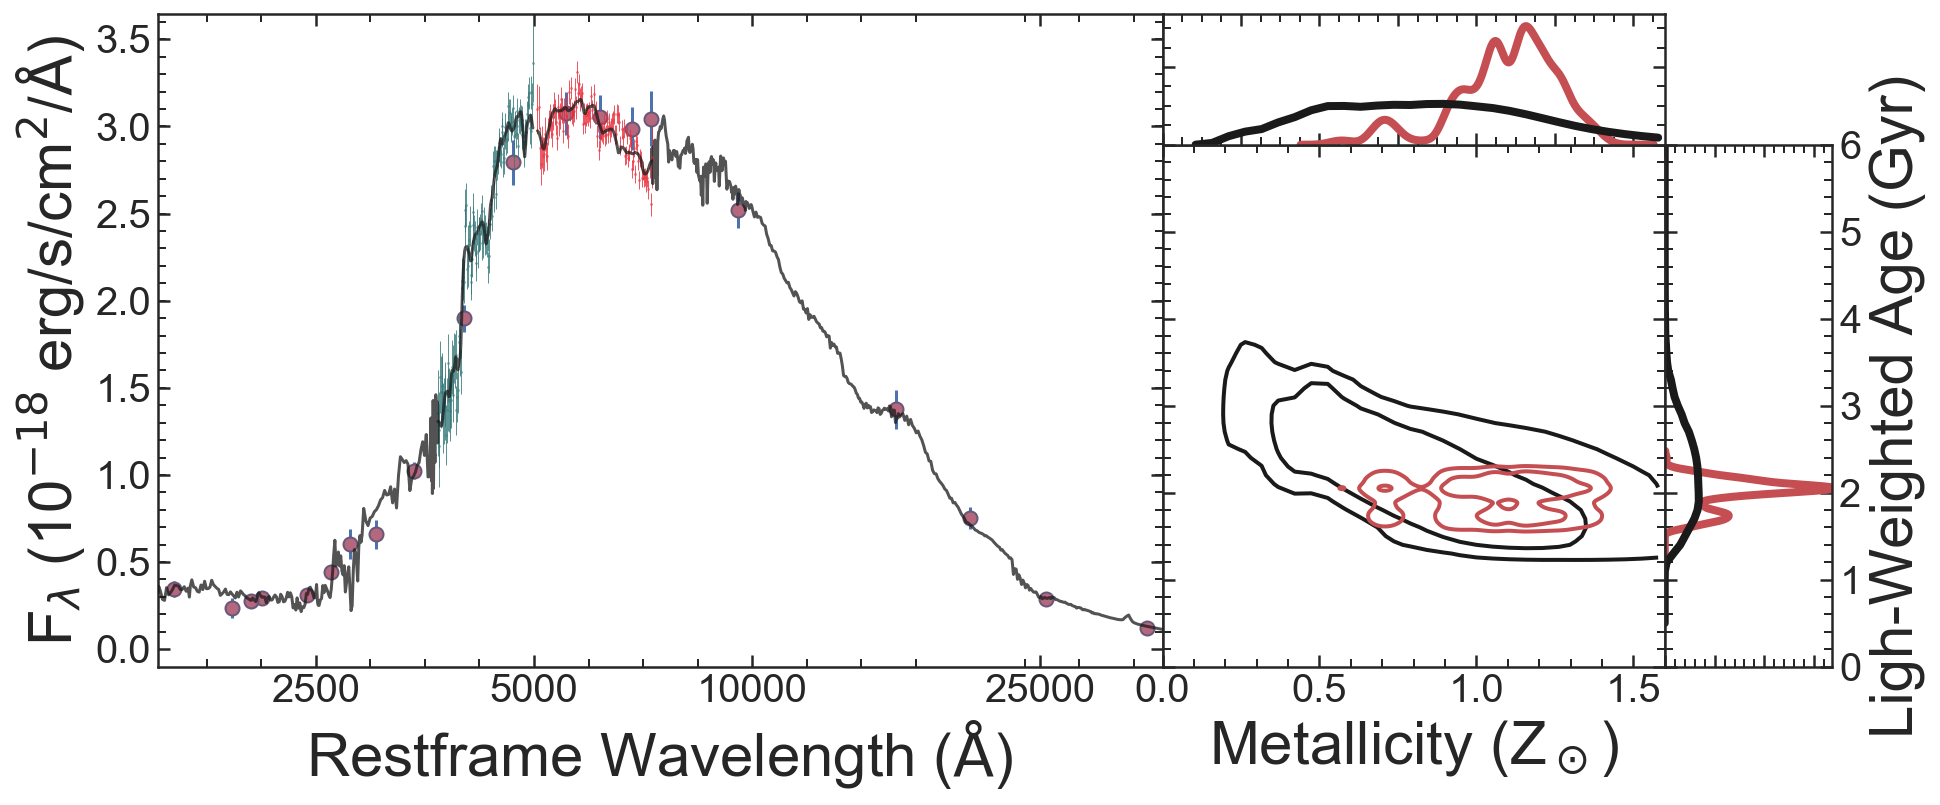

In [129]:
plt.figure(figsize=(15,6))
gs = gridspec.GridSpec(2,3, width_ratios=[6,3,1], height_ratios=[1,4], hspace=0, wspace=0)
##############plot spec##################

ax1 = plt.subplot(gs[0:,0])
if Gs.g102:
    ax1.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl *1E18,Gs.Ber *1E18,
            linestyle='None', marker='o', markersize=0.25, color='#36787A', zorder = 2, elinewidth = 0.4)
    ax1.plot(np.log10(Gs.Bwv_rf),Gs.Bmfl *1E18,'k', zorder = 4, alpha = 0.75)
    IDB = [U for U in range(len(Flam.wave)) if Flam.wave[U] < Gs.Bwv_rf[0]]
else:
    IDB = [U for U in range(len(Flam.wave)) if Flam.wave[U] < Gs.Rwv_rf[0]]

if Gs.g141:
    ax1.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl *1E18,Gs.Rer *1E18,
            linestyle='None', marker='o', markersize=0.25, color='#EA2E3B', zorder = 2, elinewidth = 0.4)
    ax1.plot(np.log10(Gs.Rwv_rf),Gs.Rmfl *1E18,'k', zorder = 4, alpha = 0.75)
    IDR = [U for U in range(len(Flam.wave)) if Flam.wave[U] > Gs.Rwv_rf[-1]]
else:
    IDR = [U for U in range(len(Flam.wave)) if Flam.wave[U] > Gs.Bwv_rf[-1]]

ax1.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
        linestyle='None', marker='o', markersize=7, markerfacecolor='#B5677D', zorder = 1,
             markeredgecolor = '#685877',markeredgewidth = 1)

ax1.plot(np.log10(Flam.wave)[IDB],Flam.SPEC[IDB]*1E18,'k', alpha = 0.75, zorder=5)
ax1.plot(np.log10(Flam.wave)[IDR],Flam.SPEC[IDR]*1E18,'k', alpha = 0.75)
ax1.set_xlim(np.log10(min(Gs.Pwv_rf)*0.95),np.log10(max(Gs.Pwv_rf)*1.05))
ax1.set_ylim(-0.1,max(Gs.Rfl *1E18)*1.1)

ax1.set_xticks(np.log10([2500,5000,10000,25000]))
ax1.set_xticklabels(np.array([2500,5000,10000,25000]))
# ax1.legend(fontsize=15, frameon = True, loc = 1)
plt.ylabel('F$_\lambda$ (10$^{-18}$ erg/s/cm$^2$/$\\rm \AA$)',size=30)
plt.xlabel('Restframe Wavelength ($\\rm \AA$)',size=30)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.minorticks_on()

ax2 = plt.subplot(gs[1,1])
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0.1, light=1.1, as_cmap=True)

plt.contour(M/ 0.019,A,P,levels,linewidths=2, colors = 'k')
plt.contour(M2,A2,MA,levels2,linewidths=2, colors = 'r')

plt.gca().tick_params(axis='y',labelleft='off')
plt.axis([0,1.6,0,6])
ax2.set_xlabel('Metallicity (Z$_\odot$)', fontsize=30)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.minorticks_on()

ax3 = plt.subplot(gs[0,1])
plt.plot(x,px, linewidth = 4, color = 'r')
plt.plot(Z/ 0.019,PZ , linewidth = 4, color = 'k')
# ax3.set_xticks([])
# ax3.set_yticks([])
ax3.set_xlim(0,1.6)
ax3.set_ylim(0,max(px)*1.1)
plt.gca().tick_params(axis='x',labelbottom='off')
plt.gca().tick_params(axis='y',labelleft='off')
ax3.minorticks_on()


ax4 = plt.subplot(gs[1,2])
plt.plot(py,y, linewidth = 4, color = 'r')
plt.plot(PT,T, linewidth = 4, color = 'k')

plt.gca().tick_params(axis='x',labelbottom='off')
plt.gca().tick_params(axis='y',labelright='on',labelleft='off')
ax4.set_ylim(0,6)
ax4.set_xlim(min(px),max(px)*1.1)
ax4.minorticks_on()
ax4.set_ylabel('Ligh-Weighted Age (Gyr)', fontsize=30)
ax4.tick_params(axis='both', which='major', labelsize=20)
ax4.yaxis.set_label_position("right")

plt.savefig('../plots/presentation_plots/GND_21156_all_results.png', bbox_inches = 'tight')

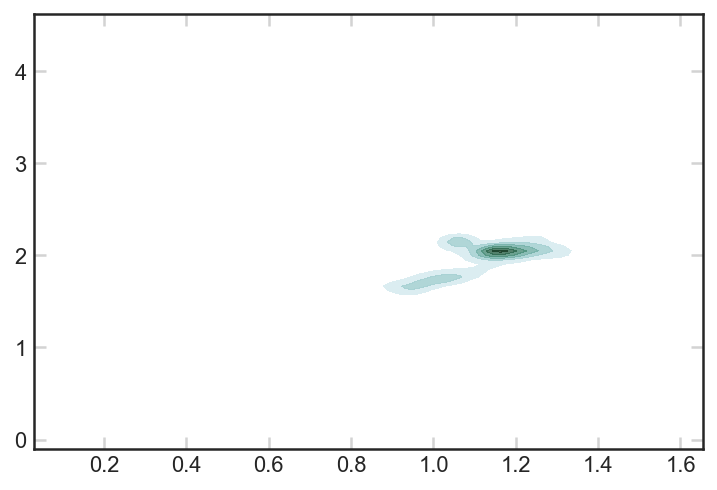

In [61]:
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0.1, light=1.1, as_cmap=True)

sea.kdeplot(Zsamp, lwasamp,n_levels = 6,alpha = .8,shade=True,kernel= 'epa',zorder=1, cmap = cmap)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in multiply
  """Entry point for launching an IPython kernel.
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/colors.py:956: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


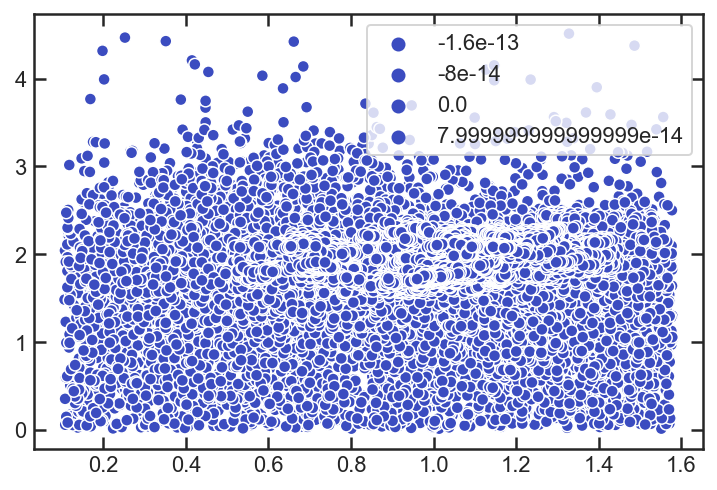

In [57]:
sea.scatterplot(Zsamp, lwasamp, hue=np.exp(dres.logwt)* 1e8, palette='coolwarm')

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in multiply
  """Entry point for launching an IPython kernel.


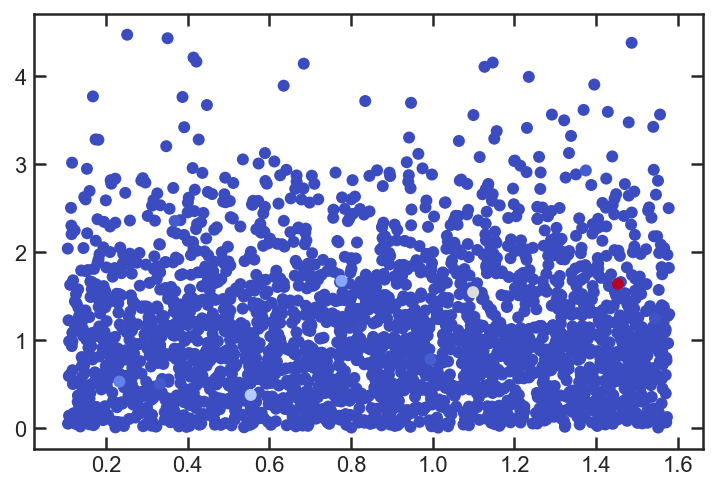

In [58]:
plt.scatter(dres.samples[:, 0], dres.samples[:, -1], marker='o', c=np.exp(dres.logwt) * 1e8, linewidths=(0.,), cmap='coolwarm')

In [115]:
x,px = np.load('../data/posteriors/GND_21156_tabfit_Pm.npy')
y,py = np.load('../data/posteriors/GND_21156_tabfit_Plwa.npy')

ipx = interp1d(x,px, fill_value=0, bounds_error=False)
ipy = interp1d(x,px, fill_value=0, bounds_error=False)

imetal = np.linspace(0.002,0.03,1000)/0.019
iage = np.linspace(0.5,6.0,1000)

M2,A2=np.meshgrid(imetal,iage)

MA = np.ones([len(iage), len(imetal)])

In [116]:
for i in range(len(MA)):
    MA[i] *=ipx(imetal)

for i in range(len(MA.T)):    
    MA.T[i] *=ipy(iage)


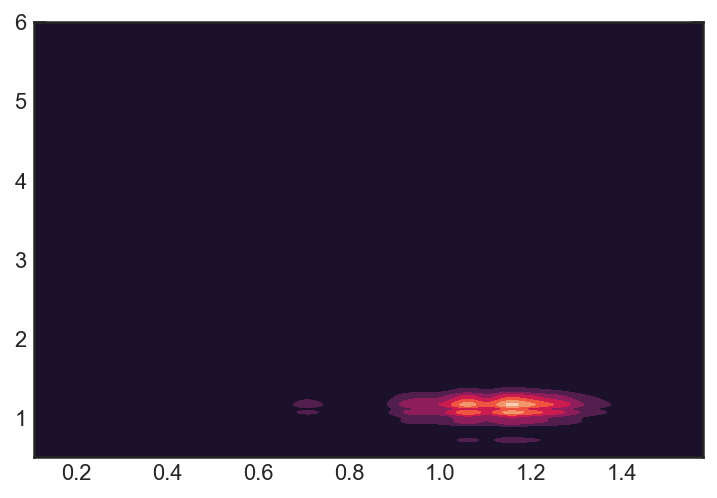

In [117]:
plt.contourf(M2, A2, MA)

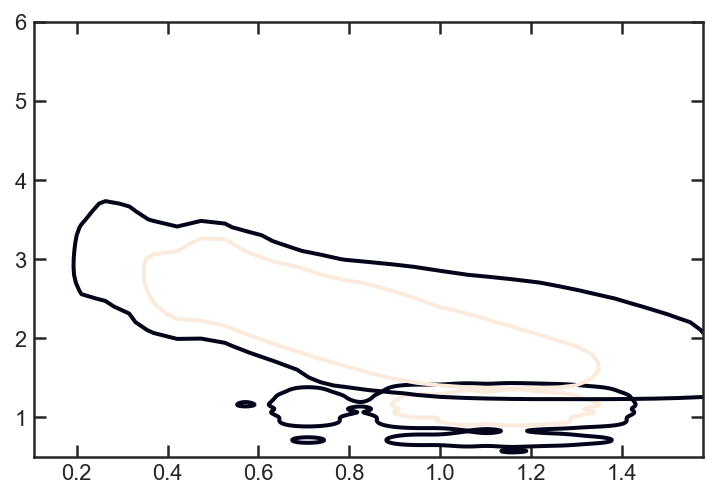

In [122]:
plt.contour(M2,A2,MA,levels2,linewidths=2)
plt.contour(M/ 0.019,A,P,levels,linewidths=2)

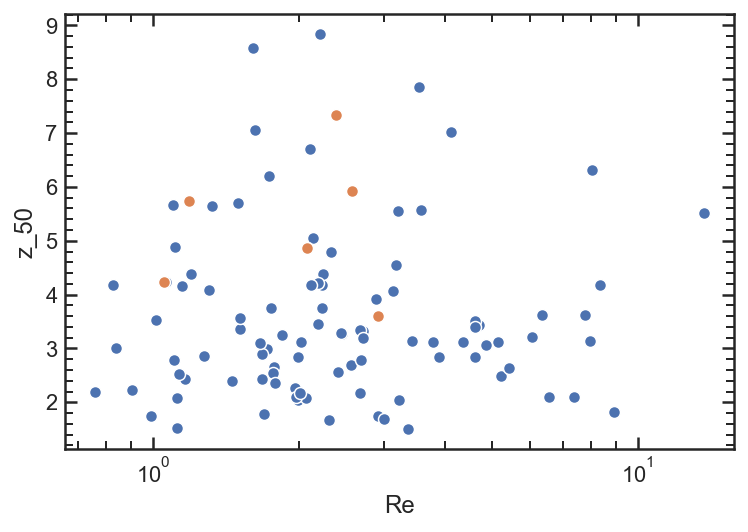

In [132]:
sea.scatterplot(mdb.Re,mdb.z_50)
sea.scatterplot(mdb.query('zgrism > 2').Re,mdb.query('zgrism > 2').z_50)

plt.xscale('log')